In [1]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total
from calculations.calculation_cf_autograd import calculation_cf_autograd
funcDevice='cpu'
# Define parameters for the central region
Ny = 2  # Number of lattice sites in the y-direction
Nx = 1  # Number of lattice sites in the x-direction
t_y = torch.tensor(2.0, dtype=torch.complex64, device=funcDevice)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64, device=funcDevice)  # Pairing potential for BdG

# Create CentralBdG instance with funcDevice=funcDevice
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matrix on CUDA

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([-20.0, 20.0], dtype=torch.float32, device=funcDevice)  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32, device=funcDevice)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32, device=funcDevice)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)  # Temperature

# Create lead objects
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]

# Set positions for leads, shifting them by one site for Python's 0-based indexing
leads_info[0].position = torch.arange(Ny, device=funcDevice)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
# Calculate eigenvalues of H_BdG
eigenvalues = torch.linalg.eigvals(H_BdG).real.sort()[0]  # Sort eigenvalues

# Create base energy grid
E = torch.tensor([0,0.1],
    dtype=torch.float32,
    device=funcDevice,
)

eta = torch.tensor(1e-8, dtype=torch.float32, device=funcDevice)  # Small imaginary part for regularization on CUDA
ginv=construct_ginv_total(H_BdG, E, eta,  leads_info)
sio.savemat('ginv.mat', {'ginv': ginv.detach().cpu().numpy()[0]})

In [7]:
sio.savemat('H_BdG.mat', {'H_BdG': H_BdG.detach().cpu().numpy()})

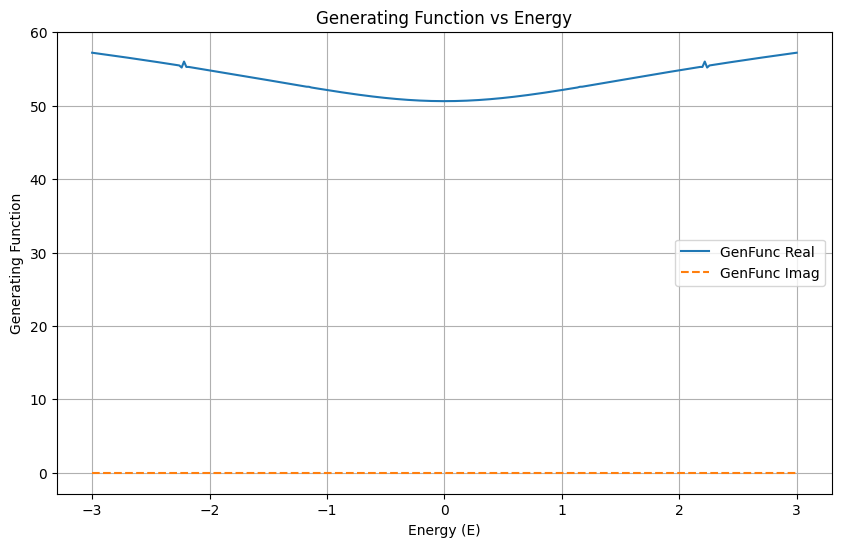

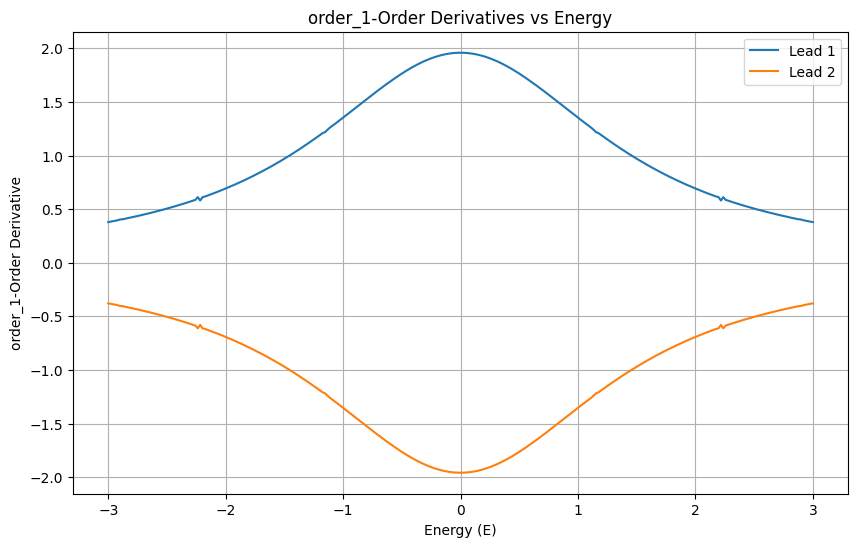

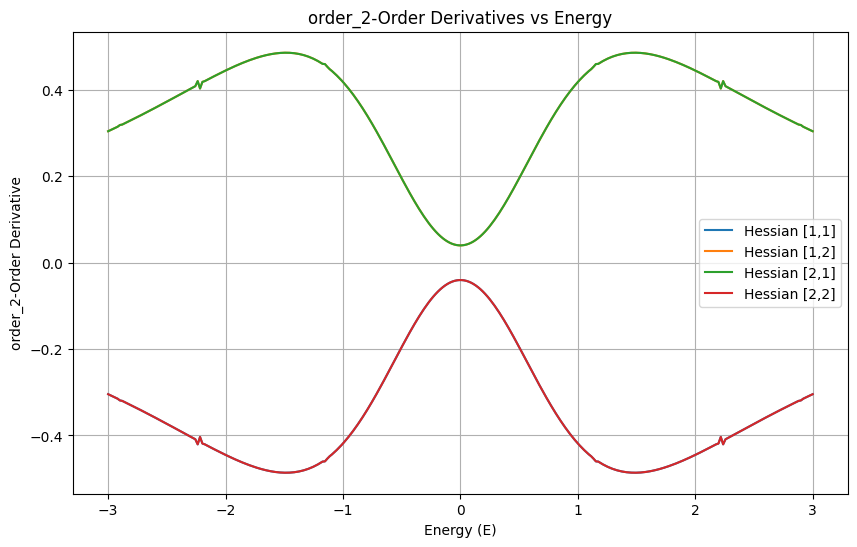

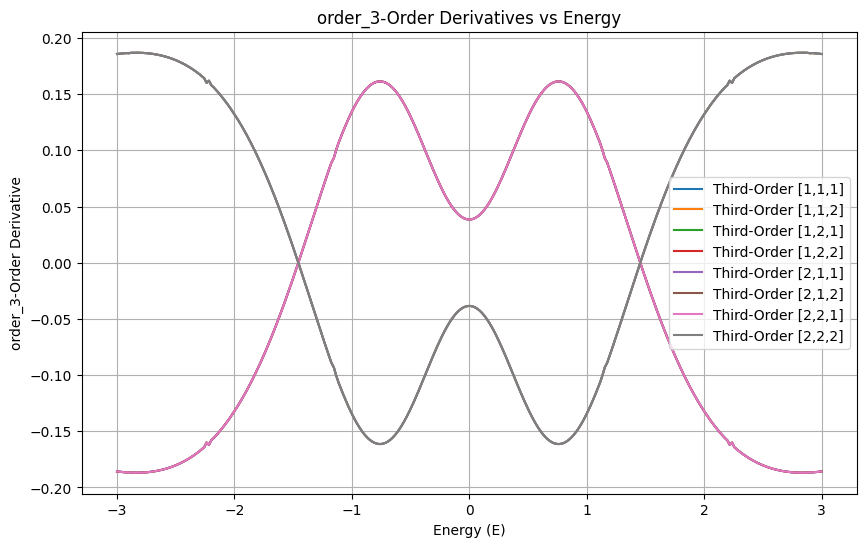

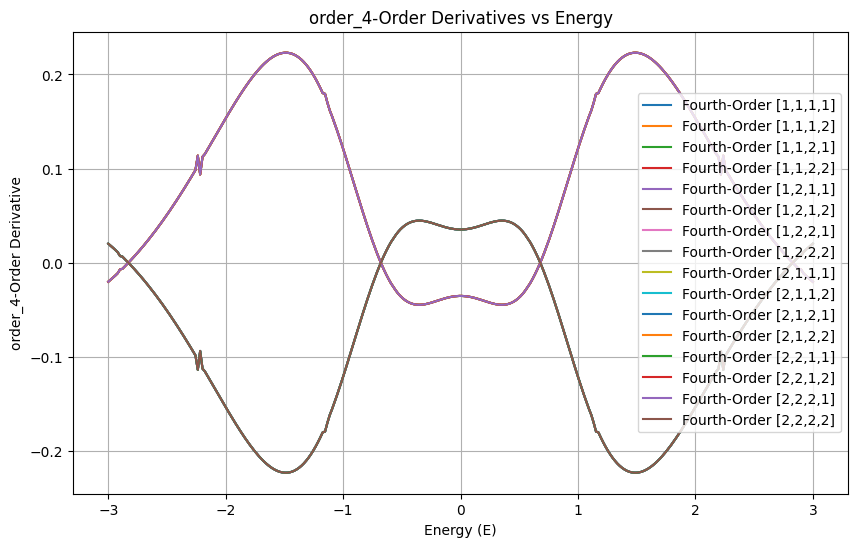

In [2]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total
from calculations.calculation_cf_autograd import calculation_cf_autograd
funcDevice='cpu'
# Define parameters for the central region
Ny = 2  # Number of lattice sites in the y-direction
Nx = 1  # Number of lattice sites in the x-direction
t_y = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64, device=funcDevice)  # Pairing potential for BdG

# Create CentralBdG instance with funcDevice=funcDevice
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matrix on CUDA

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([-20.0, 20.0], dtype=torch.float32, device=funcDevice)  # Chemical potentials for each lead
t_lead_central = torch.tensor(4.0, dtype=torch.float32, device=funcDevice)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32, device=funcDevice)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)  # Temperature

# Create lead objects
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]

# Set positions for leads, shifting them by one site for Python's 0-based indexing
leads_info[0].position = torch.arange(Ny, device=funcDevice)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
# Calculate eigenvalues of H_BdG
eigenvalues = torch.linalg.eigvals(H_BdG).real.sort()[0]  # Sort eigenvalues

# Create base energy grid
E_min, E_max = -3, 3
num_points = 300
base_E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)

# # Create finer subgrids around eigenvalues
# window_size = 0.1  # Size of window around each eigenvalue
# points_per_window = 20  # Number of points in each window
# fine_grid_points = []

# for eigenval in eigenvalues:
#     # Create fine grid around each eigenvalue
#     window_min = float(eigenval) - window_size
#     window_max = float(eigenval) + window_size
#     fine_grid = torch.linspace(window_min, window_max, steps=points_per_window, 
#                               dtype=torch.float32, device=funcDevice)
#     fine_grid_points.append(fine_grid)

# # Combine all grids
# all_grids = [base_E] + fine_grid_points + [eigenvalues]
# combined_E = torch.cat(all_grids)
# Combine all grids
all_grids = [base_E] + [eigenvalues]
combined_E = torch.cat(all_grids)
# Remove duplicates and sort
E, unique_indices = torch.unique(combined_E, sorted=True, return_inverse=True)

eta = torch.tensor(1e-8, dtype=torch.float32, device=funcDevice)  # Small imaginary part for regularization on CUDA

# Process energy values in chunks
chunk_size = 3  # Define the chunk size
results_list = []

for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    
    # Call the calculation function for the current chunk
    results = calculation_cf_autograd(H_BdG, chunked_E, eta, leads_info, max_derivative_order=4)
    results_list.append(results)

# Combine results from all chunks
combined_results = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in results_list[0]['derivatives'].keys():
    combined_results['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list], dim=0)

# Optionally, save or process the combined results
sio.savemat(f'calculation_results_size_Ny{Ny}_Nx{Nx}_chunkESize_{chunk_size}.mat', combined_results)
from dataplot.plot_all_gradients import plot_all
# Plot all results
plot_all(combined_results, E)


### compare with direct calculation

In [1]:
import torch
import scipy.io as sio
import matplotlib.pyplot as plt
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.direct_calculation import calculate_transport_properties
from calculations.calculation_cf_autograd import calculation_cf_autograd


In [6]:
import torch
import scipy.io as sio
import matplotlib.pyplot as plt
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.direct_calculation import calculate_transport_properties
from calculations.calculation_cf_autograd import calculation_cf_autograd
# Device configuration
funcDevice = 'cpu'

# System parameters
Ny = 2
Nx = 1
t_y = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
t_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
Delta = torch.tensor(0, dtype=torch.complex64, device=funcDevice)

# Create central Hamiltonian
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG

# Lead parameters
mu_values = torch.tensor([-20.0, 20.0], dtype=torch.float32, device=funcDevice)
t_lead_central = torch.tensor(4.0, dtype=torch.float32, device=funcDevice)
t_lead = torch.tensor(20.0, dtype=torch.float32, device=funcDevice)
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)

# Create leads
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]
# Set lead positions
leads_info[0].position = torch.arange(Ny, device=funcDevice)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Energy grid
E_min, E_max = -3, 3
num_points = 5
E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)
eta = torch.tensor(1e-8, dtype=torch.float32, device=funcDevice)

# Calculate using both methods
print("Calculating using direct method...")
direct_results = calculate_transport_properties(
    E_batch=E,
    H_total=H_BdG,
    leads_info=leads_info,
    temperature=temperature,
    eta=eta
)

print("Calculating using generating function method...")
gen_results = calculation_cf_autograd(
    H_BdG=H_BdG,
    E_batch=E,
    eta=eta,
    leads_info=leads_info,
    max_derivative_order=2
)

# Plotting comparison
plt.figure(figsize=(15, 10))

# Plot 1: Transmission comparison
plt.subplot(2, 2, 1)
plt.plot(E.cpu(), direct_results['transmission'][:, 0, 1].cpu(), 'b-', label='Direct - T12')
plt.plot(E.cpu(), -gen_results['derivatives']['order_1'].cpu(), 'r--', label='Generating - dF/dE')
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission Comparison')
plt.legend()
plt.grid(True)



# # Plot 3: Relative difference in transmission
# relative_diff_trans = torch.abs(direct_results['transmission'][:, 0, 1] + gen_results['derivatives']['order_1']) / \
#                      torch.abs(direct_results['transmission'][:, 0, 1])
# plt.subplot(2, 2, 3)
# plt.semilogy(E.cpu(), relative_diff_trans.cpu(), 'k-')
# plt.xlabel('Energy')
# plt.ylabel('Relative Difference')
# plt.title('Relative Difference in Transmission')
# plt.grid(True)

# Plot 4: Additional comparison (e.g., noise or current)
plt.subplot(2, 2, 4)
plt.plot(E.cpu(), direct_results['noise'][:, 0, 1].cpu(), 'b-', label='Direct - Noise')
plt.plot(E.cpu(), gen_results['derivatives']['order_2'].cpu(), 'r--', label='Generating - d²F/dE²')
plt.xlabel('Energy')
plt.ylabel('Noise/Second Derivative')
plt.title('Noise Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save comparison data
comparison_data = {
    'energy': E.cpu().numpy(),
    'direct_transmission': direct_results['transmission'].cpu().numpy(),
    'direct_dos': direct_results['rho_electron'].cpu().numpy(),
    'direct_noise': direct_results['noise'].cpu().numpy(),
    'gen_transmission': -gen_results['derivatives']['order_1'].cpu().numpy(),
    'gen_dos': gen_results['gen_func_values_imag'].cpu().numpy(),
    'gen_noise': gen_results['derivatives']['order_2'].cpu().numpy(),
    'relative_diff_trans': relative_diff_trans.cpu().numpy()
}

sio.savemat('method_comparison.mat', comparison_data)

# Print some statistics
print("\nComparison Statistics:")
print(f"Mean relative difference in transmission: {torch.mean(relative_diff_trans):.2e}")
print(f"Max relative difference in transmission: {torch.max(relative_diff_trans):.2e}")

Calculating using direct method...
Calculating using generating function method...


In [4]:
a=torch.tensor(1)
b=torch.rand(2,2)
print(a)
print(b)

tensor(1)
tensor([[0.1644, 0.3972],
        [0.2441, 0.9363]])


In [2]:
import torch
from calculations.calculation_cf_autograd import calculation_cf_autograd
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead

In [1]:
# Lattice dimensions
Nx = 50  # Length of the system
Ny = 30  # Width of the system

# Hopping parameters
t_x = torch.tensor(1.0, dtype=torch.complex64)
t_y = torch.tensor(1.0, dtype=torch.complex64)

# Magnetic flux per plaquette (related to magnetic field)
phi = torch.tensor(0.02, dtype=torch.float32)

# Disorder potential strength
U0 = torch.tensor(0.3, dtype=torch.float32)

# Other parameters
eta = 1e-5  # Small imaginary part for regularization
max_derivative_order = 2  # Maximum order of derivatives to compute

NameError: name 'torch' is not defined


2. **Define Simulation Parameters**

   Set up the parameters for your simulation, such as lattice dimensions, hopping parameters, magnetic field strength, and disorder potential.

   ```python

   ```

3. **Construct the Central Hamiltonian with Magnetic Field and Disorder**

   Use your `CentralBdG` class from 

Central.py

 to construct the Hamiltonian of the central region, incorporating the effects of the magnetic field and disorder.



In [4]:
# Define the magnetic vector potential function or Peierls phase
def peierls_phase(x_i, y_i, x_j, y_j, phi):
    return torch.exp(-0.5j * phi * (x_i - x_j) * (y_i + y_j))

# Create an instance of CentralBdG with appropriate parameters
central_hamiltonian = CentralBdG(
    Ny=Ny,
    Nx=Nx,
    t_y=t_y,
    t_x=t_x,
    Delta=torch.tensor(0.0, dtype=torch.complex64)
)

# Modify the Hamiltonian to include magnetic field and disorder
H_BdG = central_hamiltonian.H_full_BdG.clone()

# Apply Peierls substitution for magnetic field
# (This step requires modifying the hopping terms in H_BdG using peierls_phase)

# Add disorder potential to onsite energies
disorder = U0 * (torch.rand(Nx * Ny) - 0.5)
for idx in range(Nx * Ny):
    H_BdG[idx, idx] += disorder[idx]



4. **Define Leads Information**

   Set up the lead parameters using your `Lead` class from 

Lead.py

.



In [ ]:
# Define lead parameters
lead = Lead(
    t=t_x,
    epsilon=4 * t_x,  # Adjust according to your model
    # Include other necessary parameters
)

# Leads information list
leads_info = [lead]  # Add more leads if necessary



5. **Compute Energy Values**

   Define the energy range over which you want to perform the calculations.

   ```python
   # Energy values
   E_values = torch.linspace(0.0, 0.3, steps=100)  # Adjust the range and steps as needed
   ```

6. **Calculate the Generating Function and Its Derivatives**

   Use the 

calculation_cf_autograd

 function to compute the generating function and its derivatives.



In [ ]:
# Calculate generating function and derivatives
results = calculation_cf_autograd(
    H_BdG=H_BdG,
    E_batch=E_values,
    eta=eta,
    leads_info=leads_info,
    max_derivative_order=max_derivative_order
)

# Extract results
gen_func_values_real = results['gen_func_values_real']
gen_func_values_imag = results['gen_func_values_imag']
derivatives = results['derivatives']



7. **Analyze and Visualize the Results**

   Plot the results to visualize the Quantum Hall effect and the impact of disorder.

   ```python
   import matplotlib.pyplot as plt

   # Plot the real part of the generating function
   plt.figure()
   plt.plot(E_values.cpu(), gen_func_values_real)
   plt.title('Real Part of Generating Function')
   plt.xlabel('Energy')
   plt.ylabel('Real[Log Det(Ginv_total)]')
   plt.show()

   # Plot the imaginary part of the generating function
   plt.figure()
   plt.plot(E_values.cpu(), gen_func_values_imag)
   plt.title('Imaginary Part of Generating Function')
   plt.xlabel('Energy')
   plt.ylabel('Imag[Log Det(Ginv_total)]')
   plt.show()

   # Plot derivatives if needed
   # For example, plot the first-order derivative
   first_order_derivative = derivatives['order_1']
   plt.figure()
   plt.plot(E_values.cpu(), first_order_derivative.numpy())
   plt.title('First-order Derivative of Generating Function')
   plt.xlabel('Energy')
   plt.ylabel('Derivative')
   plt.show()
   ```

8. **Interpret the Results**

   Analyze the plots to understand the formation of Landau levels, edge states, and the effect of disorder in the system.

**Note:** Ensure that all the functions and classes used are properly defined in your codebase. You might need to adjust the code to match the specific implementations of your `Hamiltonian` and `Lead` classes.